<a href="https://colab.research.google.com/github/SapateAtharva/Machine-Learning-CA/blob/main/F1_Car_Computer_Vision_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and Import


In [14]:
!pip install -q roboflow tensorflow scikit-learn pandas

import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import seaborn as sns
from roboflow import Roboflow

# Download F1 Dataset

In [5]:
print("--- Downloading Dataset ---")
rf = Roboflow(api_key="Q8QURxrseX8Jw2hmw6GB")
project = rf.workspace("f1-car-detection-model").project("f1-car-classification")
dataset = project.version(2).download("multiclass")

# Define paths
train_dir = os.path.join(dataset.location, 'train')
valid_dir = os.path.join(dataset.location, 'valid')

print(f"Dataset downloaded to: {dataset.location}")

--- Downloading Dataset ---
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to F1-Car-Classification-2 in multiclass:: 100%|██████████| 7610/7610 [00:03<00:00, 2066.20it/s]


Dataset downloaded to: /content/F1-Car-Classification-2


# Load CSV Dataframes

In [6]:
print("--- Loading CSV files ---")
train_csv_path = os.path.join(train_dir, '_classes.csv')
valid_csv_path = os.path.join(valid_dir, '_classes.csv')

train_df = pd.read_csv(train_csv_path)
valid_df = pd.read_csv(valid_csv_path)

train_df.columns = train_df.columns.str.strip()
valid_df.columns = valid_df.columns.str.strip()

class_columns = [col for col in train_df.columns if col != 'filename']
num_classes = len(class_columns)

print(f"Found {num_classes} classes: {class_columns}\n")
train_df['filename'] = train_df['filename'].str.strip()
valid_df['filename'] = valid_df['filename'].str.strip()

--- Loading CSV files ---
Found 4 classes: ['Ferrari', 'Mclaren', 'Mercedes', 'Redbull']



# Set up Data Generators

In [7]:

print("--- Preparing Data Generators ---")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

print("Creating train_generator from DataFrame...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col=class_columns,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True
)

print("Creating validation_generator from DataFrame...")
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=valid_dir,
    x_col='filename',
    y_col=class_columns,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)
print("Data generators created.\n")

--- Preparing Data Generators ---
Creating train_generator from DataFrame...
Found 6657 validated image filenames.
Creating validation_generator from DataFrame...
Found 628 validated image filenames.
Data generators created.



# --- MODEL 1: CNN (MobileNetV2) ---

In [8]:
print("=========================================")
print("          TRAINING MODEL 1 (CNN)")
print("=========================================")

          TRAINING MODEL 1 (CNN)


# M1: Build the Model


In [9]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
cnn_model = Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# M1: Compile and Train

In [10]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("--- CNN Model Summary ---")
cnn_model.summary()

EPOCHS = 5
history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

print("\n--- Model 1 (CNN) Training Complete ---")


--- CNN Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 139s 548ms/step - accuracy: 0.5082 - loss: 1.1452 - val_accuracy: 0.7643 - val_loss: 0.6977
Epoch 2/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 90s 430ms/step - accuracy: 0.7720 - loss: 0.6424 - val_accuracy: 0.7818 - val_loss: 0.6288
Epoch 3/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 90s 431ms/step - accuracy: 0.7927 - loss: 0.5978 - val_accuracy: 0.7962 - val_loss: 0.5892
Epoch 4/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 88s 423ms/step - accuracy: 0.8150 - loss: 0.5171 - val_accuracy: 0.8025 - val_loss: 0.5809
Epoch 5/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 88s 423ms/step - accuracy: 0.8188 - loss: 0.5141 - val_accuracy: 0.8010 - val_loss: 0.5697

--- Model 1 (CNN) Training Complete ---


# M1: Evaluate and Plot Results


Final Validation Accuracy for Model 1 (CNN): 0.8010


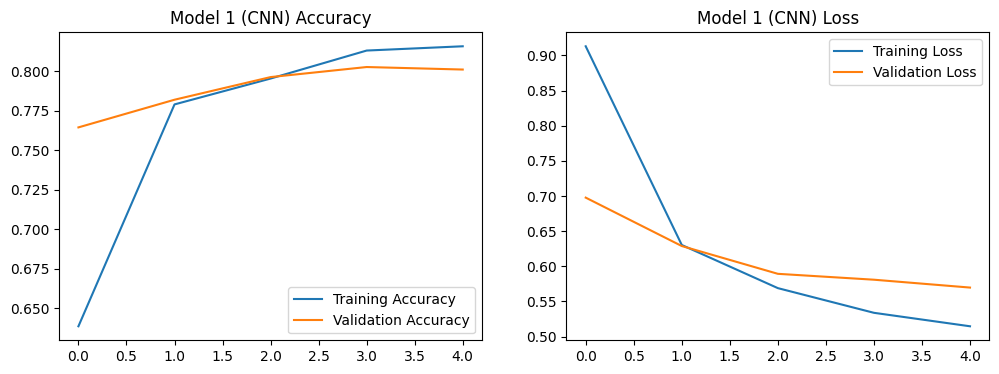

In [11]:
cnn_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy for Model 1 (CNN): {cnn_val_accuracy:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model 1 (CNN) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model 1 (CNN) Loss')
plt.show()


--- Model 1 (CNN) Detailed Report ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step
Classification Report:
              precision    recall  f1-score   support

     Ferrari       0.92      0.63      0.75       194
     Mclaren       0.83      0.81      0.82       127
    Mercedes       0.72      0.92      0.81       182
     Redbull       0.79      0.89      0.83       125

    accuracy                           0.80       628
   macro avg       0.82      0.81      0.80       628
weighted avg       0.82      0.80      0.80       628

Confusion Matrix:


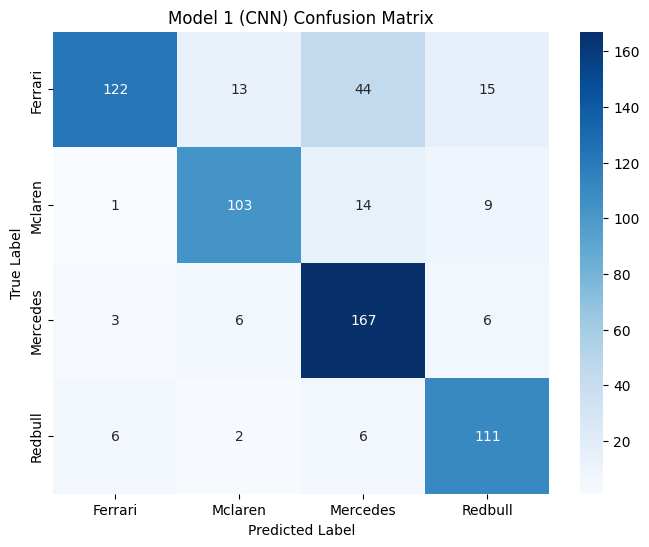

In [15]:
print("\n--- Model 1 (CNN) Detailed Report ---")
# Get predictions from the CNN model
validation_generator.reset()
predictions_cnn = cnn_model.predict(
    validation_generator,
    steps=int(np.ceil(validation_generator.samples / BATCH_SIZE))
)

# Convert predictions (probabilities) to class indices
predicted_classes_cnn = np.argmax(predictions_cnn, axis=1)

# Get the true class indices
# We use argmax on the one-hot encoded labels from the dataframe
true_classes = np.argmax(valid_df[class_columns].values, axis=1)

# 1. Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes_cnn, target_names=class_columns))

# 2. Confusion Matrix
print("Confusion Matrix:")
cm_cnn = confusion_matrix(true_classes, predicted_classes_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_columns,
    yticklabels=class_columns
)
plt.title('Model 1 (CNN) Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- MODEL 2: SVM (using CNN features) ---

In [16]:
print("\n\n=========================================")
print("       PREPARING FOR MODEL 2 (SVM)")
print("=========================================")



       PREPARING FOR MODEL 2 (SVM)


# M2: Create Feature Extractor

In [17]:
feature_extractor = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.layers[-2].output
)
print("Feature extractor model created.\n")


Feature extractor model created.



# M2: Extract Features

In [18]:
print("--- Extracting features for SVM ---")

# 1. Create a non-shuffled training generator
train_datagen_svm = ImageDataGenerator(rescale=1./255)
train_generator_svm = train_datagen_svm.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col=class_columns,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

# 2. Reset validation generator
validation_generator.reset()

# 3. Extract features from the training set
print("Extracting training features...")
features_train = feature_extractor.predict(
    train_generator_svm,
    # *** FIX 1: Cast steps to int() ***
    steps=int(np.ceil(train_generator_svm.samples / BATCH_SIZE))
)
labels_train = np.argmax(train_df[class_columns].values, axis=1)
print(f"Extracted {features_train.shape[0]} training features")

# 4. Extract features from the validation set
print("Extracting validation features...")
features_valid = feature_extractor.predict(
    validation_generator,
    # *** FIX 2: Cast steps to int() ***
    steps=int(np.ceil(validation_generator.samples / BATCH_SIZE))
)
labels_valid = np.argmax(valid_df[class_columns].values, axis=1)
print(f"Extracted {features_valid.shape[0]} validation features")

--- Extracting features for SVM ---
Found 6657 validated image filenames.
Extracting training features...


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step
Extracted 6657 training features
Extracting validation features...
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step
Extracted 628 validation features


# M2: Train the SVM

In [19]:
print("\n--- Training Model 2 (SVM) ---")

svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(features_train, labels_train)

print("--- Model 2 (SVM) Training Complete ---")


--- Training Model 2 (SVM) ---
--- Model 2 (SVM) Training Complete ---


# M2: Evaluate the SVM

Final Validation Accuracy for Model 2 (SVM): 0.8535


--- Model 2 (SVM) Detailed Report ---
Classification Report:
              precision    recall  f1-score   support

     Ferrari       0.85      0.78      0.82       194
     Mclaren       0.91      0.83      0.87       127
    Mercedes       0.79      0.92      0.85       182
     Redbull       0.92      0.89      0.90       125

    accuracy                           0.85       628
   macro avg       0.87      0.86      0.86       628
weighted avg       0.86      0.85      0.85       628

Confusion Matrix:


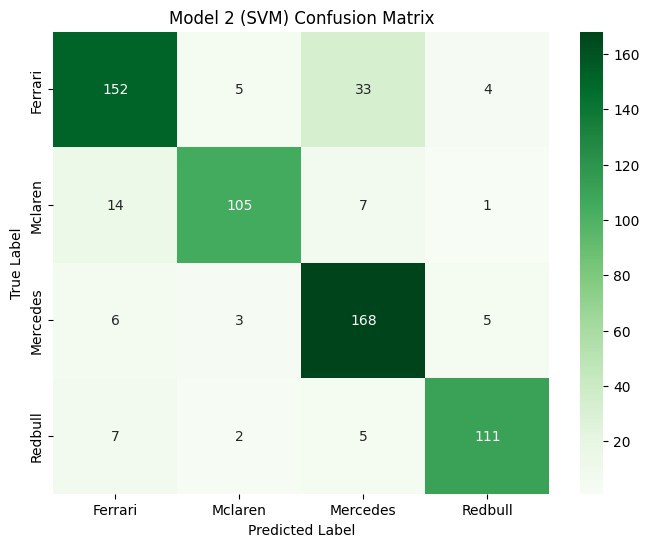

In [21]:
predictions_svm = svm_model.predict(features_valid)
svm_val_accuracy = accuracy_score(labels_valid, predictions_svm)
print(f"Final Validation Accuracy for Model 2 (SVM): {svm_val_accuracy:.4f}\n")
print("\n--- Model 2 (SVM) Detailed Report ---")
# We already have 'labels_valid' (true classes) and 'predictions_svm'

# 1. Classification Report
print("Classification Report:")
print(classification_report(labels_valid, predictions_svm, target_names=class_columns))

# 2. Confusion Matrix
print("Confusion Matrix:")
cm_svm = confusion_matrix(labels_valid, predictions_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_columns,
    yticklabels=class_columns
)
plt.title('Model 2 (SVM) Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- FINAL COMPARISON ---


           MODEL COMPARISON
Model 1 (CNN) Validation Accuracy:     0.8010
Model 2 (SVM) Validation Accuracy:     0.8535


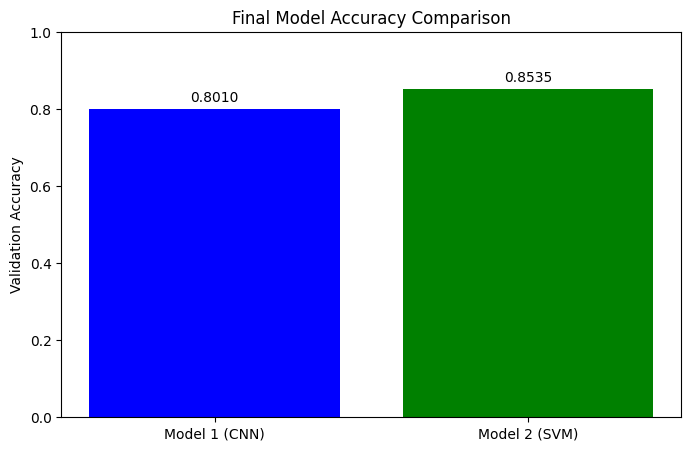

In [22]:

print("\n=========================================")
print("           MODEL COMPARISON")
print("=========================================")
print(f"Model 1 (CNN) Validation Accuracy:     {cnn_val_accuracy:.4f}")
print(f"Model 2 (SVM) Validation Accuracy:     {svm_val_accuracy:.4f}")
print("=========================================")
plt.figure(figsize=(8, 5))
models = ['Model 1 (CNN)', 'Model 2 (SVM)']
accuracies = [cnn_val_accuracy, svm_val_accuracy]
bar_colors = ['blue', 'green']

bars = plt.bar(models, accuracies, color=bar_colors)
plt.ylabel('Validation Accuracy')
plt.title('Final Model Accuracy Comparison')
plt.ylim(0.0, 1.0) # Set y-axis from 0.0 to 1.0

# Add accuracy labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.show()